In [30]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

### Prepare data

In [25]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG"]

In [26]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_dtr = create_predictdand_data(train_files)['diurnal_temperature_range'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
dtr_truth = Y_test["diurnal_temperature_range"].mean('member')

In [27]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_dtr = y_train_dtr[~nan_train_mask]
assert len(X_train) == len(y_train_dtr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
dtr_truth = dtr_truth[~nan_test_mask]

In [28]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [29]:
# Standardize predictand fields
train_dtr_mean, train_dtr_std = y_train_dtr.mean(), y_train_dtr.std()
y_train_dtr = (y_train_dtr - train_dtr_mean) / train_dtr_std

### Prepare model

In [31]:
import gpflow
from gpflow.utilities import to_default_float
from gpflow.optimizers import Scipy
from gpflow.mean_functions import Constant
from gpflow.kernels import Matern52
from gpflow.utilities import print_summary

In [32]:
def create_feature_extractor(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear'),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float64))
    ])
    return model


In [33]:
class DeepKernel(gpflow.kernels.Kernel):
    def __init__(self, feature_extractor, base_kernel, input_dim):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.base_kernel = base_kernel
        self.input_dim = input_dim

    def K(self, X, X2=None):
        # Transform X and X2 using the neural network
        X_transformed = self.feature_extractor(X)
        X2_transformed = self.feature_extractor(X2) if X2 is not None else X2
        # Compute the kernel using the transformed inputs
        return self.base_kernel(X_transformed, X2_transformed)

    def K_diag(self, X):
        X_transformed = self.feature_extractor(X)
        return self.base_kernel.K_diag(X_transformed)


In [34]:
# Define the neural network feature extractor
input_dim = X_train.shape[1]  # Number of features in X
output_dim = 24
feature_extractor = create_feature_extractor(input_dim, output_dim)

# Freeze the neural network layers to make them non-trainable in GPflow's optimization process
for layer in feature_extractor.layers:
    layer.trainable = True

# Define the base kernel and the deep kernel
kernel_CO2 = Matern52(active_dims=[0, 1], variance=1.0, lengthscales=2 * [1.])
kernel_CH4 = Matern52(active_dims=[2, 3], variance=1.0, lengthscales=2 * [1.])
kernel_BC = Matern52(active_dims=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], variance=1.0, lengthscales=10 * [1.])
kernel_SO2 = Matern52(active_dims=[14, 15, 16, 17, 18, 19, 20, 21, 22, 23], variance=1.0, lengthscales=10 * [1.])

kernel_matern12 = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

base_kernel = kernel_matern12
deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

# Mean Function
mean_function = Constant()

# Create the GP model
model = gpflow.models.GPR(data=(X_train.astype(float), y_train_dtr.astype(float)), kernel=deep_kernel, mean_function=mean_function)

# Compile the TensorFlow model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = -model.log_marginal_likelihood()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [35]:
tolerance = 1e-6  # Define tolerance
patience = 10  # Define patience

# Initialize variables for early stopping mechanism
best_loss = float('inf')
patience_counter = 0
max_iterations = 5000

# Training loop
for iteration in range(max_iterations):  # Number of optimization steps
    loss = optimization_step()

    # Early stopping logic
    if best_loss - loss < tolerance:
        patience_counter += 1
    else:
        patience_counter = 0
        best_loss = loss

    if patience_counter >= patience:
        print(f"Stopping training after {iteration + 1} iterations due to convergence.")
        break

Stopping training after 211 iterations due to convergence.


### Predict on testing set

In [36]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_dtr_std

In [37]:
# put output back into xarray format for calculating RMSE/plotting
posterior_dtr = np.reshape(posterior_mean, [86, 96, 144])
posterior_dtr_std = np.reshape(posterior_std, [86, 96, 144])

posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
posterior_dtr_std_data = xr.DataArray(posterior_dtr_std, dims=dtr_truth.dims, coords=dtr_truth.coords)

[Text(0.5, 1.0, 'Difference')]

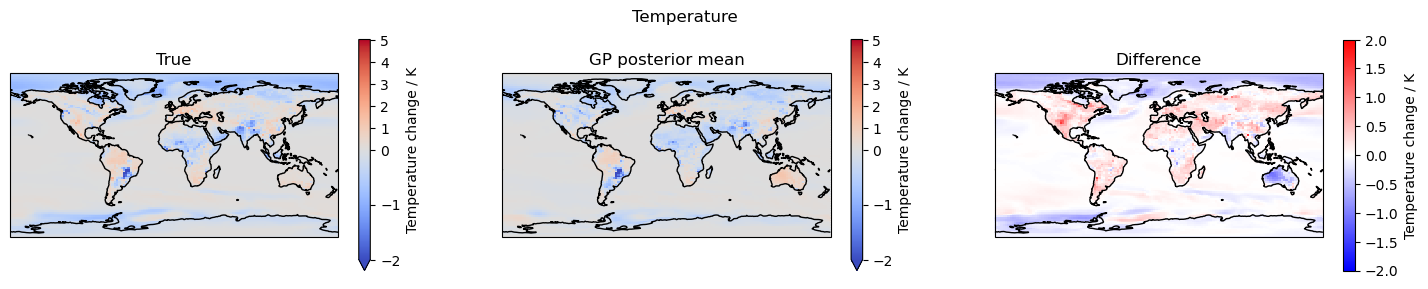

In [39]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_dtr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = dtr_truth - posterior_dtr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [40]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

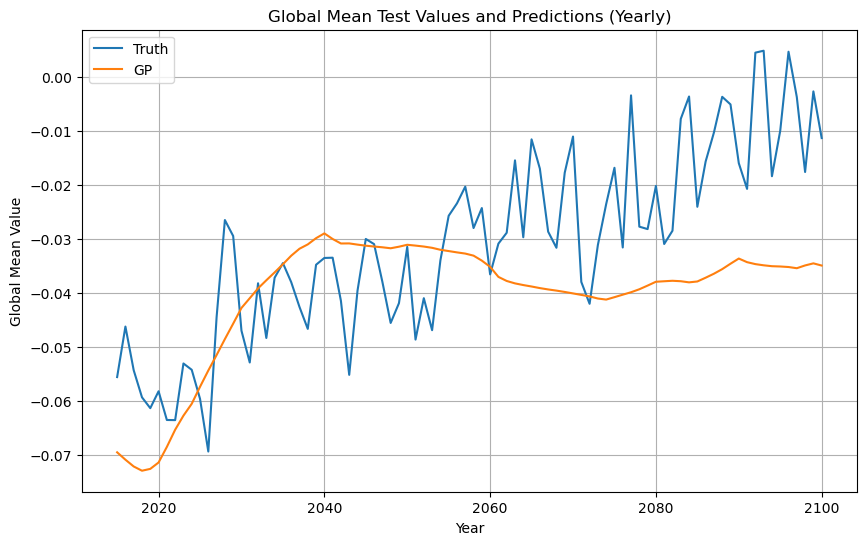

In [41]:
# t = xr.open_dataarray('climatebench-gp-posterior-mean-dtr-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(dtr_truth).plot(label="Truth")
global_mean(posterior_dtr_data).plot(label='GP')
# global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparams Tuning

In [42]:
from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from gpflow.kernels import Matern12, Matern32, Matern52, SquaredExponential, RationalQuadratic, Cosine, Periodic, Polynomial, ArcCosine, Exponential
import keras
import math
from gpflow.mean_functions import Constant
from xskillscore import rmse
from ray.tune import CLIReporter

In [45]:
def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

weights = np.cos(np.deg2rad(dtr_truth.lat)).expand_dims(lon=144).assign_coords(lon=dtr_truth.lon)
    
def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(3)
    return total

In [46]:
def make_feature_extractor(dim_max, activation, input_dim, output_dim, dropout_prob, bnorm=True, dropout=True):
    model = tf.keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    
    dimensions = [dim_max // (2 ** i) for i in range(int(math.log(dim_max, 2)) + 1) if dim_max // (2 ** i) > input_dim]

    for dim in dimensions[::-1]:
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    for dim in dimensions:
        if dim <= output_dim:
            break
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    model.add(keras.layers.Dense(output_dim, activation='linear'))
    model.add(keras.layers.Lambda(lambda x: tf.cast(x, tf.float64)))
        
    return model

In [47]:
def basekernel(kernel_types, active_dim_multiplier, variance=1.0, lengthscales=1.0):
    kernels = {
        'Matern12': Matern12, 'Matern32': Matern32, 'Matern52': Matern52, 'SquaredExponential': SquaredExponential, 'RationalQuadratic': RationalQuadratic, 'Cosine':Cosine, 'Periodic': Periodic,
        'Polynomial': Polynomial, 'ArcCosine': ArcCosine, 'Exponential': Exponential
    }
    dims = [x for x in range(12*active_dim_multiplier)]
    def CO2(kernel):
        active_dims = dims[0:active_dim_multiplier*1]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k

    def CH4(kernel):
        active_dims = dims[1*active_dim_multiplier:active_dim_multiplier*2]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k
        
    def BC(kernel):
        active_dims = dims[2*active_dim_multiplier:active_dim_multiplier*2 + 5*active_dim_multiplier]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k

    def SO2(kernel):
        active_dims = dims[active_dim_multiplier*2 + 5*active_dim_multiplier:]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k
    
    kernel = CO2(kernels[kernel_types[0]]) + CH4(kernels[kernel_types[1]]) + BC(kernels[kernel_types[2]]) + SO2(kernels[kernel_types[3]])

    return kernel

In [51]:
def objective(config, return_pred=False):  # ①
    input_dim = X_train.shape[1]  # Number of features in X
    
    output_dim = config["output_dim"]
    # Feature extractor for deep kernel
    feature_extractor = make_feature_extractor(
        config["dim_max"], config["activation"], input_dim, config["output_dim"], config["dropout_prob"], bnorm=config["bnorm"], dropout=config["dropout"]
    )
    
    # Freeze the neural network layers to make them non-trainable in GPflow's optimization process
    for layer in feature_extractor.layers:
        layer.trainable = True
    
    # Define kernel
    base_kernel = basekernel(
        config["kernel_types"], config["active_dim_multiplier"]
    )
    deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

    mean_function = Constant() # Define Mean function

    optimizer  = tf.keras.optimizers.Adam(learning_rate=config["optimizer_lr"])# Define opt

    model = gpflow.models.GPR(data=(X_train.astype(float), y_train_dtr.astype(float)), kernel=deep_kernel, mean_function=mean_function)
    

    # custom optimizer
    @tf.function
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            loss = -model.log_marginal_likelihood()
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss


    # Training
    tolerance, patience = 1e-6, 10  # Define tolerance and patience

    # Initialize variables for early stopping mechanism
    best_loss, patience_counter, max_iterations = float('inf'), 0, 5000
    
    # Training loop
    for iteration in range(max_iterations):  # Number of optimization steps
        loss = optimization_step()
    
        # Early stopping logic
        if best_loss - loss < tolerance:
            patience_counter += 1
        else:
            patience_counter = 0
            best_loss = loss
    
        if patience_counter >= patience:
            print(f"Stopping training after {iteration + 1} iterations due to convergence.")
            break

    # Eval
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
    posterior_std = np.sqrt(standard_posterior_var) * train_dtr_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_dtr = np.reshape(posterior_mean, [86, 96, 144])
    posterior_dtr_std = np.reshape(posterior_std, [86, 96, 144])
    
    posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
    posterior_dtr_std_data = xr.DataArray(posterior_dtr_std, dims=dtr_truth.dims, coords=dtr_truth.coords)

    total_NRMSE = TNRMSE(dtr_truth, posterior_dtr_data)

    if return_pred:
        return posterior_dtr_data, posterior_dtr_std_data


    return {'nrmse':total_NRMSE}

In [52]:
def run_tuner(search_space, num_samples=50):
    algo = HyperOptSearch()
    
    tuner = tune.Tuner(  # ③
        tune.with_resources(
            objective,
            resources={"cpu": 1, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="nrmse",
            mode="min",
            num_samples=num_samples,
            search_alg=algo,
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    return results

In [53]:
search_space_2 = {
        "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
        "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 512]), 
        "output_dim": tune.choice([36, 48, 60, 72, 84]), "optimizer_lr": tune.choice([0.01, 0.001, 0.0001])
    }  # ②

search_space_1 = {
    "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
    "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52'], 4*['SquaredExponential']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 64]), 
    "output_dim": tune.choice([12, 24, 36, 48, 60]), "optimizer_lr": tune.choice([0.01, 0.001])
} 

run_tuner(search_space_1)

2024-02-26 01:27:06,374	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
2024-02-26 01:27:29,322	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
2024-02-26 01:27:43,024	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
2024-02-26 01:28:05,290	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
2024-02-26 01:28:22,417	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


ResultGrid<[
  Result(
    metrics={'nrmse': 25.626},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-26_01-26-36/objective_202cee6b_1_activation=tanh,active_dim_multiplier=1,bnorm=True,dim_max=128,dropout=True,dropout_prob=0.5000,kernel_types=_2024-02-26_01-26-37',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 37.118},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-26_01-26-36/objective_0e8929cd_2_activation=relu,active_dim_multiplier=1,bnorm=True,dim_max=256,dropout=False,dropout_prob=0.5000,kernel_types_2024-02-26_01-26-48',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 34.201},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-26_01-26-36/objective_5a9ac5c7_3_activation=relu,active_dim_multiplier=1,bnorm=True,dim_max=256,dropout=True,dropout_prob=0.5000,kernel_types=_2024-02-26_01-27-06',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 33.035},
 

In [55]:
temp = _.get_dataframe()
best_config = _.get_best_result()

In [56]:
temp.to_csv('model configs and dfs/grid_search_1_pr.csv')

In [57]:
temp_sorted = temp.sort_values(by='nrmse')
temp_sorted_config = temp_sorted[[col for col in temp_sorted.columns if 'config' in col]]

In [58]:
temp_sorted

,nrmse,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,config/activation,config/bnorm,config/dropout,config/dropout_prob,config/kernel_types,config/active_dim_multiplier,config/dim_max,config/output_dim,config/optimizer_lr,logdir
28,13.482,1708936578,None,False,1,ccdbfd49,2024-02-26_01-36-18,8.469996,8.469996,10552,...,sigmoid,False,True,0.5,"(Matern52, Matern52, Matern52, Matern52)",1,128,36,0.010,ccdbfd49
34,15.986,1708936664,None,False,1,9b3c46a8,2024-02-26_01-37-44,8.547165,8.547165,12635,...,sigmoid,False,True,0.5,"(Matern52, Matern52, Matern52, Matern52)",1,128,12,0.010,9b3c46a8
11,16.182,1708936254,None,False,1,5491548e,2024-02-26_01-30-54,8.906095,8.906095,8967,...,sigmoid,False,True,0.5,"(Matern52, Matern52, Matern52, Matern52)",1,128,36,0.010,5491548e
40,16.682,1708936749,None,False,1,4d8ea3c6,2024-02-26_01-39-09,8.538827,8.538827,13282,...,sigmoid,False,True,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,64,12,0.010,4d8ea3c6
24,16.764,1708936530,None,False,1,6a424695,2024-02-26_01-35-30,10.382902,10.382902,10552,...,sigmoid,False,False,0.5,"(Matern32, Matern32, Matern32, Matern32)",2,128,36,0.010,6a424695
41,21.983,1708936758,None,False,1,549e7553,2024-02-26_01-39-18,9.059129,9.059129,13282,...,sigmoid,False,True,0.5,"(Matern52, Matern52, Matern52, Matern52)",1,128,12,0.010,549e7553
39,22.153,1708936740,None,False,1,34860dcd,2024-02-26_01-39-00,7.730673,7.730673,13282,...,sigmoid,False,True,0.5,"(Matern52, Matern52, Matern52, Matern52)",1,256,12,0.010,34860dcd
38,22.153,1708936732,None,False,1,7848bebe,2024-02-26_01-38-52,7.970061,7.970061,13282,...,sigmoid,False,True,0.5,"(Matern52, Matern52, Matern52, Matern52)",1,256,12,0.010,7848bebe
31,22.504,1708936636,None,False,1,4a6795cc,2024-02-26_01-37-16,8.459130,8.459130,12635,...,sigmoid,False,True,0.5,"(Matern52, Matern52, Matern52, Matern52)",1,128,36,0.010,4a6795cc
36,22.862,1708936684,None,False,1,5879fa42,2024-02-26_01-38-04,8.522705,8.522705,12635,...,sigmoid,False,True,0.5,"(Matern52, Matern52, Matern52, Matern52)",1,128,12,0.010,5879fa42


In [82]:
temp_sorted_config.iloc[5]

config/activation                                                sigmoid
config/bnorm                                                       False
config/dropout                                                      True
config/dropout_prob                                                  0.5
config/kernel_types             (Matern52, Matern52, Matern52, Matern52)
config/active_dim_multiplier                                           1
config/dim_max                                                       128
config/output_dim                                                     12
config/optimizer_lr                                                 0.01
Name: 41, dtype: object

In [77]:
best_config.config

{'activation': 'sigmoid',
 'bnorm': False,
 'dropout': True,
 'dropout_prob': 0.5,
 'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52'),
 'active_dim_multiplier': 1,
 'dim_max': 128,
 'output_dim': 36,
 'optimizer_lr': 0.01}

In [78]:
t = {
    "activation": "sigmoid", "bnorm": False, "dropout": False, 'dropout_prob': 0.5,
        "kernel_types": 4*['Matern32'], "active_dim_multiplier":2, "dim_max": 128, 
        "output_dim": 36, "optimizer_lr": 0.01
}
mean_best, std_best = objective(t, return_pred=True)

Stopping training after 369 iterations due to convergence.


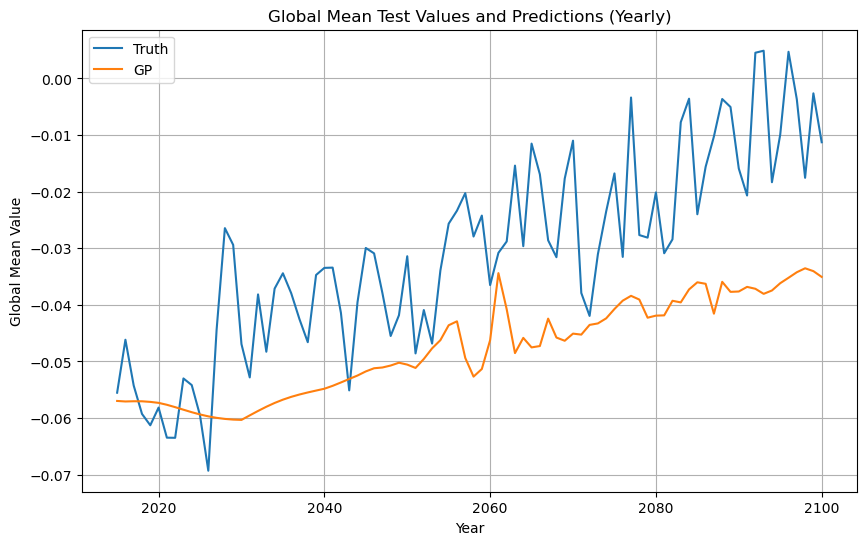

In [79]:
plt.figure(figsize=(10, 6))
global_mean(pr_truth).plot(label="Truth")
global_mean(mean_best).plot(label='GP')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

[Text(0.5, 1.0, 'Difference')]

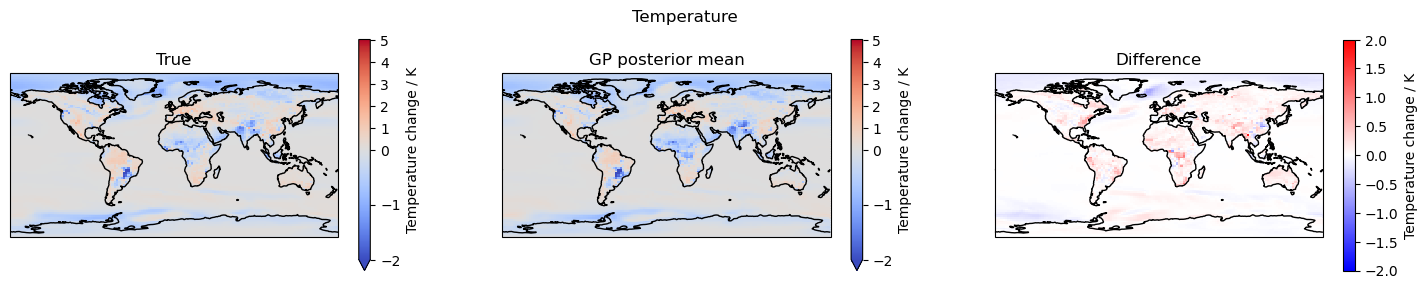

In [80]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mean_best.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - mean_best
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [81]:
mean_best.to_netcdf('model/final-gp-interesting-model-mean-dtr.nc')
std_best.to_netcdf('model/final-gp-interesting-model-std-dtr.nc')